# Solution - Siamese Network (CNN+LRN)

The proposed Siamese network contains two identical convolutional neural networks (CNNs) and a logistic regression network (LRN). The CNNs are utilized to extract image features and the LRN is responsible for comparing the similarity of these features.

In our current project, we're leveraging the Siamese Net architecture for similarity learning, primarily focusing on the CEDAR dataset due to compatibility issues with other datasets. Similarity learning is a branch of supervised machine learning that aims to teach models how to gauge the similarity between two objects, returning a high score for similar objects and a low score for dissimilar ones. This approach finds application in various scenarios, including one-shot classification, where Siamese networks come into play. Siamese networks consist of identical sub-networks with shared configurations, parameters, and weights.

The operational flow of a Siamese network begins with the comparison of two images to determine their similarity. Each image passes through a subnetwork independently, resulting in vector representations (encodings) of the images. These encodings are then compared to assess the degree of similarity between the images. If the images are similar, their encodings will exhibit proximity, while dissimilar images will yield more distinct encodings. This comparison is typically performed by measuring the distance between the two vectors, with smaller distances indicating similarity and larger distances indicating dissimilarity.

In terms of optimizing the Siamese network, various loss functions are employed. One common choice is the Contrastive Loss Function, which evaluates the network's ability to discriminate between pairs of images. Another option is the Triplet Loss Function, which encourages the model to map similar images closer together and dissimilar images farther apart in the embedding space. This is achieved by computing the distance between three vectors: an anchor image, a positive sample (similar to the anchor), and a negative sample (dissimilar to the anchor), using metrics such as L2 distance or cosine distance. By minimizing this loss, the Siamese network learns to effectively distinguish between similar and dissimilar image pairs, facilitating tasks like image retrieval and similarity-based classification.

## Important Libraries 

In [1]:
import time
import copy
import numpy as np
import pandas as pd
from datetime import datetime
from statistics import mean

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from itertools import combinations

import random
from tqdm import tqdm # Progress Bar

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
from statistics import mean

import cv2

import itertools
import random
import os

from sklearn.metrics import classification_report, confusion_matrix

# Move the processed image to a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [2]:
root_data_path = "C:/Users/harsh/Downloads/Signature"
train_path = root_data_path + "/CEDAR/CEDAR"
val_path = root_data_path + "/CEDAR/CEDAR"
test_path = root_data_path + "/CEDAR/CEDAR"

## Data Analysis

### Image Samples

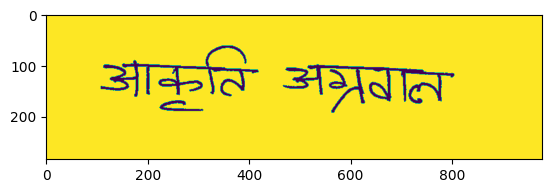

In [3]:
img = plt.imread('C:/Users/harsh/Downloads/Signature/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-F-01.tif')
plt.imshow(img)

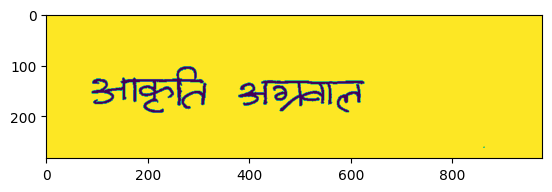

In [4]:
img = plt.imread('C:/Users/harsh/Downloads/Signature/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-01.tif')
plt.imshow(img)

### Analysis

In [12]:
bengali_forgeries_imgs = []
bengali_original_imgs = []

hindi_forgeries_imgs = []
hindi_original_imgs = []

cedar_forgeries_imgs = []
cedar_original_imgs = []

for dataset in os.listdir(root_data_path):
  dataset_path = root_data_path + "/" + dataset + "/" + dataset
  if not dataset in ["BHSig260-Hindi", "BHSig260-Bengali", "CEDAR"]:
    continue
  for folder in os.listdir(dataset_path):
    folder_path = dataset_path + "/" + folder
    for img in os.listdir(folder_path):
      img_path = folder_path + "/" + img
      if dataset == "BHSig260-Hindi":
        if img.split("-")[3] == "F":
          hindi_forgeries_imgs.append(img_path)
        else:
          hindi_original_imgs.append(img_path)
      elif dataset == "BHSig260-Bengali":
        if img.split("-")[3] == "F":
          bengali_forgeries_imgs.append(img_path)
        else:
          bengali_original_imgs.append(img_path)
      elif dataset == "CEDAR":
        if img.split("_")[0] == "forgeries":
          cedar_forgeries_imgs.append(img_path)
        else:
          cedar_original_imgs.append(img_path)

all_forge_imgs = cedar_forgeries_imgs+hindi_forgeries_imgs+bengali_forgeries_imgs
all_org_imgs = cedar_original_imgs+hindi_original_imgs+bengali_original_imgs

In [13]:
print(len(cedar_forgeries_imgs), len(cedar_original_imgs))

1320 1320


In [14]:
print(len(hindi_forgeries_imgs), len(hindi_original_imgs))

4800 3840


In [15]:
print(len(bengali_forgeries_imgs), len(bengali_original_imgs))

3000 2400


In [16]:
print(len(all_forge_imgs),len(all_org_imgs))

9120 7560


In [17]:
img = cv2.imread(all_forge_imgs[0])
img.shape

(696, 882, 3)

In [18]:
img = cv2.imread(all_org_imgs[0])
img.shape

(517, 612, 3)

### Data Preprocessing

The preprocessing pipeline begins by converting the image to grayscale, eliminating color information for computational efficiency. Erosion followed by dilation operations are applied to remove minor noise and bridge gaps within the image, refining its structure. GaussianBlur enhances edge details by smoothing the grayscale image, reducing noise impact. Subsequently, binarization simplifies the image into a binary format, facilitating foreground-background separation. Finally, cropping isolates the signature or region of interest, focusing on essential image components for further analysis or recognition tasks.

In [30]:
def preprocess_image(image_pth):

    gray = image_pth.convert("L")

    img = np.array(gray)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,2))
    morphology_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1)

    blur = cv2.GaussianBlur(morphology_img, (3,3),0)

    _, binary = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    coords = cv2.findNonZero(binary)
    x, y, w, h = cv2.boundingRect(coords)

    padding = 5
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding

    x = max(0, x)
    y = max(0, y)
    w = min(w, img.shape[1] - x)
    h = min(h, img.shape[0] - y)

    cropped_image = binary[y:y + h, x:x + w]

    extra_space = np.zeros((cropped_image.shape[0] + 2 * padding, cropped_image.shape[1] + 2 * padding), dtype=np.uint8) * 255
    extra_space[padding:-padding, padding:-padding] = cropped_image

    corrected = cv2.resize(extra_space,(330,175))
    resized_image = Image.fromarray(corrected)

    return resized_image

In [31]:
def plot_images(img):
    fig, axes = plt.subplots(1,2, figsize=(10,10))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title("before_preprocessing")

    after_preprocessing = preprocess_image(img)
    print(after_preprocessing.size)
    axes[1].imshow(after_preprocessing)
    axes[1].axis('off')
    axes[1].set_title("after_preprocessing")

(330, 175)


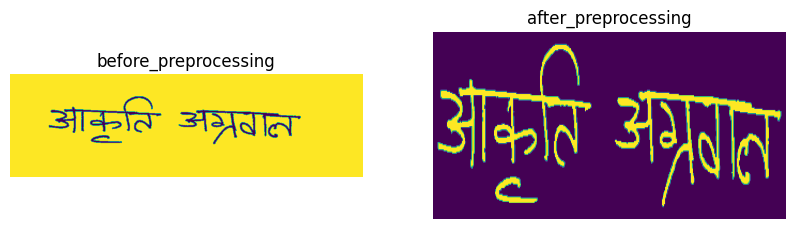

In [32]:
img = Image.open("C:/Users/harsh/Downloads/Signature/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-F-01.tif")
plot_images(img)

In [34]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p  # Probability of applying Gaussian noise

    def __call__(self, tensor):
        if torch.rand(1) < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        return tensor

In [35]:
transformation = transforms.Compose([
    transforms.Resize((200,300)),
    transforms.ToTensor(),
    transforms.RandomRotation((-5,5)),
    AddGaussianNoise(mean=0.0, std=0.1,p=0.3),
])

In [36]:
def show_triplets_from_dataloader(dataloader, num_triplets=3):
    for batch_idx, (anchor_imgs, positive_imgs, negative_imgs) in enumerate(dataloader):
        for i in range(len(anchor_imgs)):
            if i >= num_triplets:
                break

            # Display the anchor, positive, and negative images
            fig, axes = plt.subplots(1, 3, figsize=(8, 4))
            axes[0].imshow(anchor_imgs[i].permute(1, 2, 0))  # Permute dimensions for image display (assuming tensor input)
            axes[0].set_title("Anchor")
            axes[1].imshow(positive_imgs[i].permute(1, 2, 0))
            axes[1].set_title("Positive")
            axes[2].imshow(negative_imgs[i].permute(1, 2, 0))
            axes[2].set_title("Negative")
            plt.tight_layout()
            plt.show()

### Triplet Dataset - Dataset with three pairs (Anchor, Positive, Negative)

In [37]:
def all_forge_img(data_path):

  forge_imgs = []
  for signature in os.listdir(data_path):
    signature_path = os.path.join(data_path, signature)
    for filename in os.listdir(signature_path):
      if 'forgeries' in filename or '-F-' in filename or 'forge' in filename:
        forge_imgs.append(os.path.join(signature_path,filename))

  return forge_imgs

In [38]:
def triplet_dataset_preparation(data_path):

  all_forge_imgs = all_forge_img(data_path)

  df = pd.DataFrame(columns=['Anchor_Path', 'Positive_Path', 'Negative_Path'])

  for signature_folder in os.listdir(data_path):
    signature_folder_path = os.path.join(data_path, signature_folder)
    genuine_images = []
    forged_images = []
    for filename in os.listdir(signature_folder_path):
      if 'original' in filename or '-G-' in filename:
        genuine_images.append(os.path.join(signature_folder_path,filename))
      if 'forgeries' in filename or '-F-' in filename or 'forge' in filename:
        forged_images.append(os.path.join(signature_folder_path,filename))

    forged_images.extend(random.sample(all_forge_imgs, 15))

    num_combinations = min(len(genuine_images) * (len(genuine_images) - 1) // 2, len(genuine_images) * len(forged_images))
    genuine_combinations = random.sample(list(itertools.combinations(genuine_images, 2)), num_combinations)
    forged_combinations = random.sample(list(itertools.product(genuine_images, forged_images)), num_combinations)

    data = []
    for (image_1, image_2), (genuine_image, forged_image) in zip(genuine_combinations, forged_combinations):
      anchor_path = os.path.join(image_1)
      positive_path = os.path.join(image_2)
      negative_path = os.path.join(forged_image)
      data.append([anchor_path, positive_path, negative_path])

    df_ext = pd.DataFrame(data, columns=['Anchor_Path', 'Positive_Path', 'Negative_Path'])

    df = pd.concat([df, df_ext], ignore_index=True)
  return df

### Dulet Dataset - Dataset with two pairs (Original, Forge)

In [39]:
def duplet_dataset_preparation(data_path):

  all_forge_imgs = all_forge_img(data_path)

  df = pd.DataFrame(columns=['Image1', 'Image2', 'Label'])

  for signature_folder in os.listdir(data_path):
    signature_folder_path = os.path.join(data_path, signature_folder)
    genuine_images = []
    forged_images = []
    for filename in os.listdir(signature_folder_path):
      if 'original' in filename or '-G-' in filename:
        genuine_images.append(os.path.join(signature_folder_path,filename))
      if 'forgeries' in filename or '-F-' in filename or 'forge' in filename:
        forged_images.append(os.path.join(signature_folder_path, filename))

    forged_images.extend(random.sample(all_forge_imgs, 15))

    num_combinations = min(len(genuine_images) * (len(genuine_images) - 1) // 2, len(genuine_images) * len(forged_images))
    genuine_combinations = random.sample(list(itertools.combinations(genuine_images, 2)), num_combinations)
    forged_combinations = random.sample(list(itertools.product(genuine_images, forged_images)), num_combinations)

    data = []
    for (image_1, image_2), (genuine_image, forged_image) in zip(genuine_combinations, forged_combinations):
      anchor_path = os.path.join(image_1)
      positive_path = os.path.join(image_2)
      label = 1
      data.append([anchor_path, positive_path, label])

      anchor_path = os.path.join(genuine_image)
      positive_path = os.path.join(forged_image)
      label = 0
      data.append([anchor_path, positive_path, label])

    df_ext = pd.DataFrame(data, columns=['Image1', 'Image2', 'Label'])

    df = pd.concat([df, df_ext], ignore_index=True)

  return df

### Dataset Inference

In [40]:
class TripletDataset(Dataset):

    def __init__(self, training_df=None,transform=None):
        self.training_df = training_df
        self.training_df.columns = ["Anchor_Path", "Positive_Path", "Negative_Path"]
        self.transform = transform

    def __getitem__(self, index):
        # Getting the image paths
        anchor_path = os.path.join(self.training_df.iat[int(index), 0])
        positive_path = os.path.join(self.training_df.iat[int(index), 1])
        negative_path = os.path.join(self.training_df.iat[int(index), 2])

        # Loading the images
        anchor_img = Image.open(anchor_path)
        positive_img = Image.open(positive_path)
        negative_img = Image.open(negative_path)

        # preprocess the image
        anchor_img = preprocess_image(anchor_img)
        positive_img = preprocess_image(positive_img)
        negative_img = preprocess_image(negative_img)

        # Apply image transformations
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.training_df)


class DupletDataset(Dataset):

    def __init__(self,dataframe=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=dataframe
        self.training_df.columns =["image1","image2","label"]
        self.transform = transform

    def __getitem__(self,index):

        # getting the image path
        image1_path=os.path.join(self.training_df.iat[int(index),0])
        image2_path=os.path.join(self.training_df.iat[int(index),1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)

        img0 = preprocess_image(img0)
        img1 = preprocess_image(img1)

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        label = torch.from_numpy(np.array([int(self.training_df.iat[int(index), 2])], dtype=np.float32))

        return img0, img1 , label

    def __len__(self):
        return len(self.training_df)

##### data for CNN

In [42]:
train_df_triplet = triplet_dataset_preparation(train_path)
# val_df_triplet = triplet_dataset_preparation(val_path)
# test_df_triplet = triplet_dataset_preparation(test_path)

#train_df_triplet = train_df_triplet.sample(32000, random_state=42)
print(train_df_triplet.shape)

(15180, 3)


In [43]:
train_df_triplet.sample(10)

,Anchor_Path,Positive_Path,Negative_Path
8816,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...
2310,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...
6857,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...
11651,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...
9017,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...
13549,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...
7455,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...
10129,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...
5460,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...
14607,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...


In [44]:
train_dataset =  TripletDataset(train_df_triplet, transform = transformation)

batch_size = 128
triplet_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size)

In [45]:
len(triplet_train_loader)

119

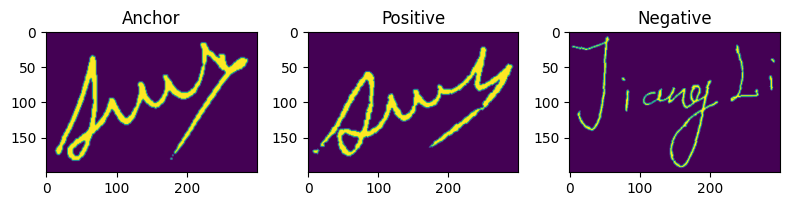

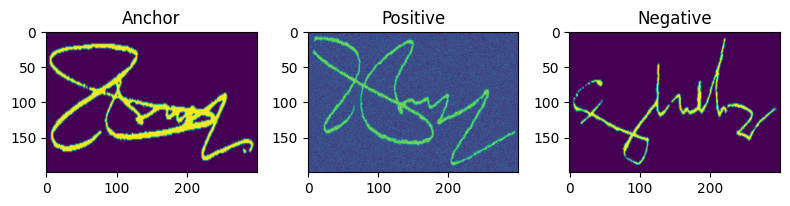

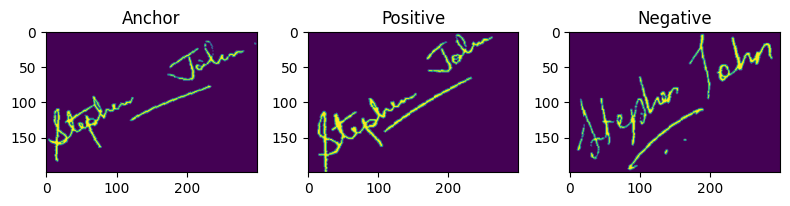

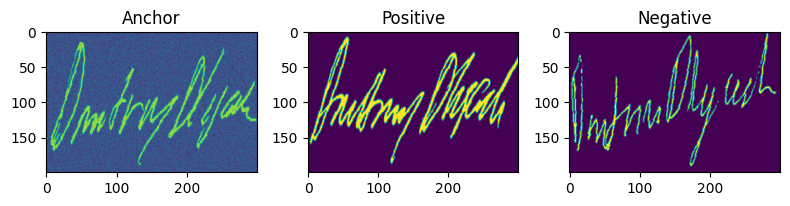

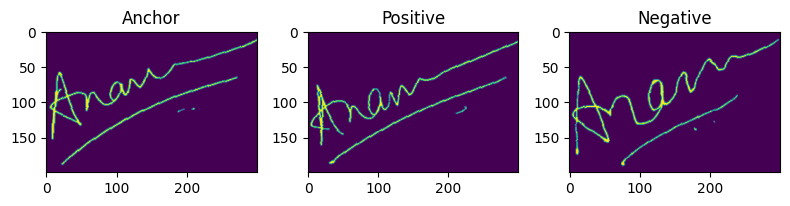

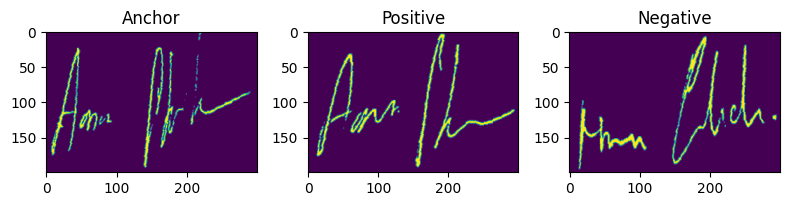

In [46]:
num_samples_to_show = 6

# Get random indices to select samples from the DataLoader
num_samples = len(triplet_train_loader.dataset)
random_indices = np.random.choice(num_samples, num_samples_to_show, replace=False)

# Create a SubsetRandomSampler using the random indices
sampler = SubsetRandomSampler(random_indices)

# Create a new DataLoader using the SubsetRandomSampler
random_loader = DataLoader(train_dataset, batch_size=1, sampler=sampler)

# Show the random samples
show_triplets_from_dataloader(random_loader, num_samples_to_show)

##### Data for LRN

In [47]:
train_duplet = duplet_dataset_preparation(train_path)

# train_duplet = train_duplet.sample(42000, random_state=42)
duplet_train_dataset = DupletDataset(train_duplet, transform=transformation)

indices = list(range(len(duplet_train_dataset)))

split = int(np.floor(0.80 * len(duplet_train_dataset)))  # train_size
validation = int(np.floor(0.70 * split))   # validation
np.random.shuffle(indices)

train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)


batch_size = 128
train_loader = torch.utils.data.DataLoader(
    duplet_train_dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    duplet_train_dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    duplet_train_dataset, batch_size=batch_size, sampler=validation_sampler
)

In [48]:
train_duplet.sample(10)

,image1,image2,label
10609,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,0
1118,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,1
19957,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,0
22512,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,1
110,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,1
16628,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,1
16429,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,0
19440,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,1
4555,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,0
25878,/kaggle/input/handwritten-signature-datasets/C...,/kaggle/input/handwritten-signature-datasets/C...,1


In [49]:
len(train_loader)

133

## CNN Model Pipeline

Combining ResNet50 with CBAM, or Convolutional Block Attention Module, enhances the network's feature refinement capabilities. CBAM integrates channel attention mechanism (CAM) and spatial attention mechanism (SAM) into each convolutional block, enabling the model to selectively focus on relevant features across both channel and spatial dimensions. ResNet50, an extension of ResNet-34, further augments this architecture by introducing deeper layers and skip connections, effectively mitigating the vanishing gradient problem and facilitating the training of deeper neural networks. Together, ResNet50 with CBAM constitutes a powerful framework for feature extraction and attention-guided feature refinement in convolutional neural networks, enabling more efficient and effective learning of complex patterns in image data.

### Model classes

In [50]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)
        avg_out = self.fc2(self.relu(self.fc1(avg_pool)))
        max_out = self.fc2(self.relu(self.fc1(max_pool)))
        attention = self.sigmoid(avg_out + max_out)
        return x * attention


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        pool = torch.cat([avg_pool, max_pool], dim=1)
        attention = self.sigmoid(self.conv(pool))
        return x * attention


class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8, spatial_kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(spatial_kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x


class SiameseResNet(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=False):
        super(SiameseResNet, self).__init__()
        self.baseModel = models.resnet18(pretrained=pretrained)

        # Experiment with different spatial sizes based on the image resolution and signature complexity
        self.attention1 = CBAM(in_channels=64)  # CBAM for layer 1
        self.attention2 = CBAM(in_channels=256)  # CBAM for layer 3

        self.baseModel.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the fully connected layer
        self.baseModel.fc = nn.Identity()

    def forward(self, x):
        out = self.baseModel.conv1(x)
        out = self.baseModel.bn1(out)
        out = self.baseModel.relu(out)
        out = self.baseModel.maxpool(out)

        out = self.attention1(self.baseModel.layer1(out))  # Applying CBAM to layer 1
        out = self.baseModel.layer2(out)
        out = self.attention2(self.baseModel.layer3(out))  # Applying CBAM to layer 3
        out = self.baseModel.layer4(out)

        # Global Average Pooling (GAP)
        out = F.adaptive_avg_pool2d(out, (1, 1))  # Perform GAP to reduce spatial dimensions to 1x1
        out = torch.flatten(out, 1)
        return out

class TriangularMarginLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TriangularMarginLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_anchor_positive = F.pairwise_distance(anchor, positive, p=2)
        distance_anchor_negative = F.pairwise_distance(anchor, negative, p=2)

        # Triangular Margin Loss
        loss = torch.relu(distance_anchor_positive - distance_anchor_negative + self.margin)

        return loss.mean()

def train_model(model, loader, n_epochs, optimizer, loss_fn):
    history = {'train_loss': []}
    print("------------------------Training--------------------------")
    for epoch in range(1, n_epochs + 1):
        t0 = datetime.now()
        print(f"Beginning Epoch {epoch}/{n_epochs}...")
        train_loss = []
        model.train()
        for i, data in tqdm(enumerate(loader, 0)):
            anchor, positive, negative = data
            anchor = anchor.to(device=device)
            positive = positive.to(device=device)
            negative = negative.to(device=device)

            optimizer.zero_grad()
            anchor_embeddings = model(anchor)
            positive_embeddings = model(positive)
            negative_embeddings = model(negative)

            loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)  # Changed `triplet_loss` to `loss_fn`

            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())  # Added the loss value to `train_loss` list

        dt = datetime.now() - t0
        print('\nEpoch: {}\tTrain Loss: {}\tDuration: {}'.format(epoch, np.mean(train_loss), dt))

        # Tracking loss in each epoch for plot
        history['train_loss'].append(np.mean(train_loss))

    return history

### Training Model

In [51]:
margin = 0.1

# Create an instance of SiameseResnet with the ResNet model and embedding size
siamese_model = SiameseResNet()
siamese_model = nn.DataParallel(siamese_model).to(device)

triplet_loss = TriangularMarginLoss(margin).to(device)
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=0.001)

In [52]:
num_epochs = 10

history = train_model(siamese_model, triplet_train_loader, num_epochs, optimizer, triplet_loss)

------------------------Training--------------------------
Beginning Epoch 1/10...


119it [08:01,  4.05s/it]



Epoch: 1	Train Loss: 0.08472942750355103	Duration: 0:08:01.993231
Beginning Epoch 2/10...


119it [07:46,  3.92s/it]



Epoch: 2	Train Loss: 0.01907363879013055	Duration: 0:07:46.267366
Beginning Epoch 3/10...


119it [07:46,  3.92s/it]



Epoch: 3	Train Loss: 0.005652691959109972	Duration: 0:07:46.551945
Beginning Epoch 4/10...


119it [07:47,  3.92s/it]



Epoch: 4	Train Loss: 0.002806950464723397	Duration: 0:07:47.022469
Beginning Epoch 5/10...


119it [07:43,  3.90s/it]



Epoch: 5	Train Loss: 0.0014019344063640078	Duration: 0:07:43.618393
Beginning Epoch 6/10...


119it [07:43,  3.89s/it]



Epoch: 6	Train Loss: 0.0016078961208000966	Duration: 0:07:43.135476
Beginning Epoch 7/10...


119it [07:43,  3.89s/it]



Epoch: 7	Train Loss: 0.0032336634374419307	Duration: 0:07:43.180205
Beginning Epoch 8/10...


119it [07:41,  3.88s/it]



Epoch: 8	Train Loss: 0.0037787051890006275	Duration: 0:07:41.503333
Beginning Epoch 9/10...


119it [07:43,  3.90s/it]



Epoch: 9	Train Loss: 0.002049794900935425	Duration: 0:07:43.697138
Beginning Epoch 10/10...


119it [07:41,  3.87s/it]


Epoch: 10	Train Loss: 7.571598041426985e-05	Duration: 0:07:41.107414


In [53]:
torch.save(siamese_model.state_dict(),'/kaggle/working/signature_forgery_detection_model')

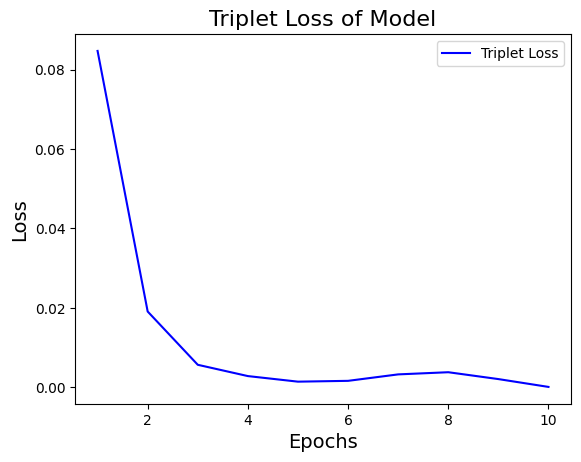

In [54]:
plt.plot(range(1,11), history['train_loss'], 'b', label='Triplet Loss')
plt.title('Triplet Loss of Model', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

### Model Inference

In [55]:
def get_similarity(img1, img2):
    fig, axes = plt.subplots(1,2, figsize=(8,8))
    # Load the images
    image1 = Image.open(img1)
    image1 = preprocess_image(image1)
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[0].set_title("Genuine Image")

    image2 = Image.open(img2)
    image2 = preprocess_image(image2)
    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title("Test Image")


    # Preprocess the images
    transform = transforms.Compose([
        transforms.Resize((175,330)),
        transforms.ToTensor(),
    ])
    input1 = transform(image1).unsqueeze(0).to(device)
    input2 = transform(image2).unsqueeze(0).to(device)

    # Make predictions using the model
    siamese_model.eval()
    with torch.no_grad():
        pred1 = siamese_model(input1)
        pred2 = siamese_model(input2)

        dist = torch.pairwise_distance(pred1, pred2)
        similarity_score = 1 / (1 + dist)

        print(similarity_score)

tensor([0.5992], device='cuda:0')


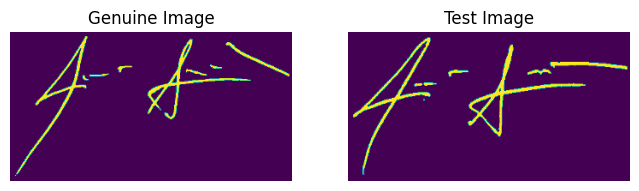

In [56]:
img1 = '/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/1/original_1_2.png'
img2 = '/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/1/original_1_3.png'
get_similarity(img1, img2)

tensor([0.4755], device='cuda:0')


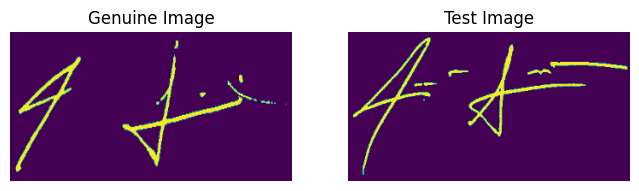

In [57]:
img1 = '/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/1/forgeries_1_1.png'
img2 = '/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/1/original_1_3.png'
get_similarity(img1, img2)

tensor([0.4677], device='cuda:0')


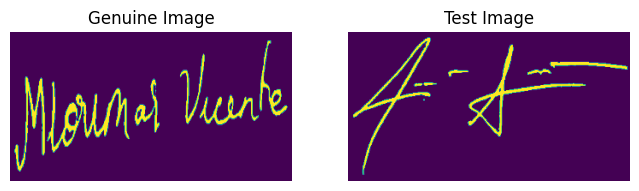

In [58]:
img1 = '/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/2/forgeries_2_1.png'
img2 = '/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/1/original_1_3.png'
get_similarity(img1, img2)

## Logistic Regression (LRN)

Logistic regression is used for binary classification where we use sigmoid function, that takes input as independent variables and produces a probability value between 0 and 1.

For example, we have two classes Class 0 and Class 1 if the value of the logistic function for an input is greater than 0.5 (threshold value) then it belongs to Class 1 otherwise it belongs to Class 0. It's referred to as regression because it is the extension of linear regression but is mainly used for classification problems.

### Model Classes

In [59]:
class LogisticSiameseRegression(nn.Module):
    def __init__(self, model):
        super(LogisticSiameseRegression, self).__init__()

        self.model = model
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128,1),
            nn.LeakyReLU(inplace=True)

        )
        self.sigmoid = nn.Sigmoid()


    def forward_once(self, x):
        out = self.model(x)
        out = F.normalize(out, p=2, dim=1)
        return out

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)

        diff = out1 - out2
        out = self.fc(diff)
        out = self.sigmoid(out)

        return out

In [60]:
def train(model, input1, input2, outputs, optimizer, loss_fn):
    # Set the model to training mode
    model.train()
    # Zero the gradients
    optimizer.zero_grad()
    # Compute the model's predictions
    predictions = model(input1, input2)
    # Compute the loss
    loss = loss_fn(predictions, outputs)
    # Compute the gradients
    loss.backward()
    # Update the weights
    optimizer.step()
    return loss, predictions

threshold = 0.8
def train_model(model, train_loader, test_loader, n_epochs, optimizer, loss_fn):
    history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}
    print("------------------------Training--------------------------")

    for epoch in range(1, n_epochs + 1):
        t0 = datetime.now()
        print(f"Beginning Epoch {epoch}/{n_epochs}...")
        train_loss = []
        train_acc = []
        model.train()
        for i, data in tqdm(enumerate(train_loader, 0)):
            inputs1, inputs2, targets = data
            inputs1 = inputs1.to(device=device)
            inputs2 = inputs2.to(device=device)
            targets = targets.to(device=device)

            loss, predictions = train(model, inputs1, inputs2, targets, optimizer, loss_fn)
            train_loss.append(loss.item())
            accuracy = ((predictions >= threshold).float() == targets).float().mean().item()
            train_acc.append(accuracy)

        valid_loss = []
        valid_acc = []
        model.eval()
        with torch.no_grad():
            for i, data in tqdm(enumerate(test_loader, 0)):
                inputs1, inputs2, targets = data
                inputs1 = inputs1.to(device=device)
                inputs2 = inputs2.to(device=device)
                targets = targets.to(device=device)

                output = model(inputs1, inputs2)
                loss = loss_fn(output, targets)
                valid_loss.append(loss.item())
                accuracy = ((output >= threshold).float() == targets).float().mean().item()
                valid_acc.append(accuracy)

        dt = datetime.now() - t0
        print('\nEpoch: {}\t\tTrain Loss: {:.4f}\tTrain Accuracy: {:.4f}\nDuration: {}\tValid Loss: {:.4f}\tValid Accuracy: {:.4f}\n'.format(
             epoch, np.mean(train_loss), np.mean(train_acc), dt, np.mean(valid_loss), np.mean(valid_acc)
        ))

        # Tracking accuracy and loss in each epoch for plot
        history['train_loss'].append(np.mean(train_loss))
        history['train_acc'].append(np.mean(train_acc))
        history['valid_loss'].append(np.mean(valid_loss))
        history['valid_acc'].append(np.mean(valid_acc))

    return history

In [61]:
def plot_acc_loss(history, num_epochs):

    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    axes[0].plot(range(1, num_epochs+1), history['train_acc'], 'b', label='Training Accuracy')
    axes[0].plot(range(1, num_epochs+1), history['valid_acc'], 'r', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy of Model', fontsize=16)
    axes[0].set_xlabel('Epochs', fontsize=14)
    axes[0].set_ylabel('Accuracy', fontsize=14)
    axes[0].legend()

    axes[1].plot(range(1, num_epochs+1), history['train_loss'], 'b', label='Training Loss')
    axes[1].plot(range(1, num_epochs+1), history['valid_loss'], 'r', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss of Model', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=14)
    axes[1].set_ylabel('Loss', fontsize=14)
    axes[1].legend()

    plt.show()

### Model Training

In [62]:
l2_reg = 1e-5
model_rms = LogisticSiameseRegression(siamese_model).to(device)
loss_fn = nn.BCELoss().to(device)
epochs = 10

optimizer = torch.optim.Adam(model_rms.parameters(), lr=0.001, weight_decay=l2_reg)
history = train_model(model_rms, train_loader, test_loader, epochs, optimizer, loss_fn)

------------------------Training--------------------------
Beginning Epoch 1/10...


133it [05:55,  2.67s/it]
48it [01:46,  2.22s/it]



Epoch: 1		Train Loss: 0.5892	Train Accuracy: 0.5976
Duration: 0:07:41.909999	Valid Loss: 0.5591	Valid Accuracy: 0.5494

Beginning Epoch 2/10...


133it [05:56,  2.68s/it]
48it [01:49,  2.29s/it]



Epoch: 2		Train Loss: 0.4699	Train Accuracy: 0.6567
Duration: 0:07:46.339435	Valid Loss: 0.5165	Valid Accuracy: 0.6237

Beginning Epoch 3/10...


133it [05:52,  2.65s/it]
48it [01:47,  2.24s/it]



Epoch: 3		Train Loss: 0.3936	Train Accuracy: 0.7668
Duration: 0:07:39.723822	Valid Loss: 0.4982	Valid Accuracy: 0.6681

Beginning Epoch 4/10...


133it [05:52,  2.65s/it]
48it [01:51,  2.31s/it]



Epoch: 4		Train Loss: 0.3513	Train Accuracy: 0.8069
Duration: 0:07:43.488786	Valid Loss: 0.4803	Valid Accuracy: 0.6995

Beginning Epoch 5/10...


133it [06:03,  2.74s/it]
48it [01:52,  2.33s/it]



Epoch: 5		Train Loss: 0.2526	Train Accuracy: 0.8701
Duration: 0:07:55.909722	Valid Loss: 0.4397	Valid Accuracy: 0.7243

Beginning Epoch 6/10...


133it [06:04,  2.74s/it]
48it [01:54,  2.38s/it]



Epoch: 6		Train Loss: 0.1832	Train Accuracy: 0.9109
Duration: 0:07:58.360804	Valid Loss: 0.3170	Valid Accuracy: 0.7752

Beginning Epoch 7/10...


133it [06:04,  2.74s/it]
48it [01:48,  2.26s/it]



Epoch: 7		Train Loss: 0.1363	Train Accuracy: 0.9394
Duration: 0:07:52.379167	Valid Loss: 0.5897	Valid Accuracy: 0.7087

Beginning Epoch 8/10...


133it [05:46,  2.61s/it]
48it [01:47,  2.23s/it]



Epoch: 8		Train Loss: 0.1320	Train Accuracy: 0.9356
Duration: 0:07:33.878472	Valid Loss: 0.3781	Valid Accuracy: 0.7356

Beginning Epoch 9/10...


133it [05:50,  2.64s/it]
48it [01:49,  2.28s/it]



Epoch: 9		Train Loss: 0.0837	Train Accuracy: 0.9630
Duration: 0:07:39.950131	Valid Loss: 0.4808	Valid Accuracy: 0.7554

Beginning Epoch 10/10...


133it [05:53,  2.66s/it]
48it [01:49,  2.28s/it]


Epoch: 10		Train Loss: 0.0761	Train Accuracy: 0.9637
Duration: 0:07:43.200995	Valid Loss: 0.3696	Valid Accuracy: 0.7854



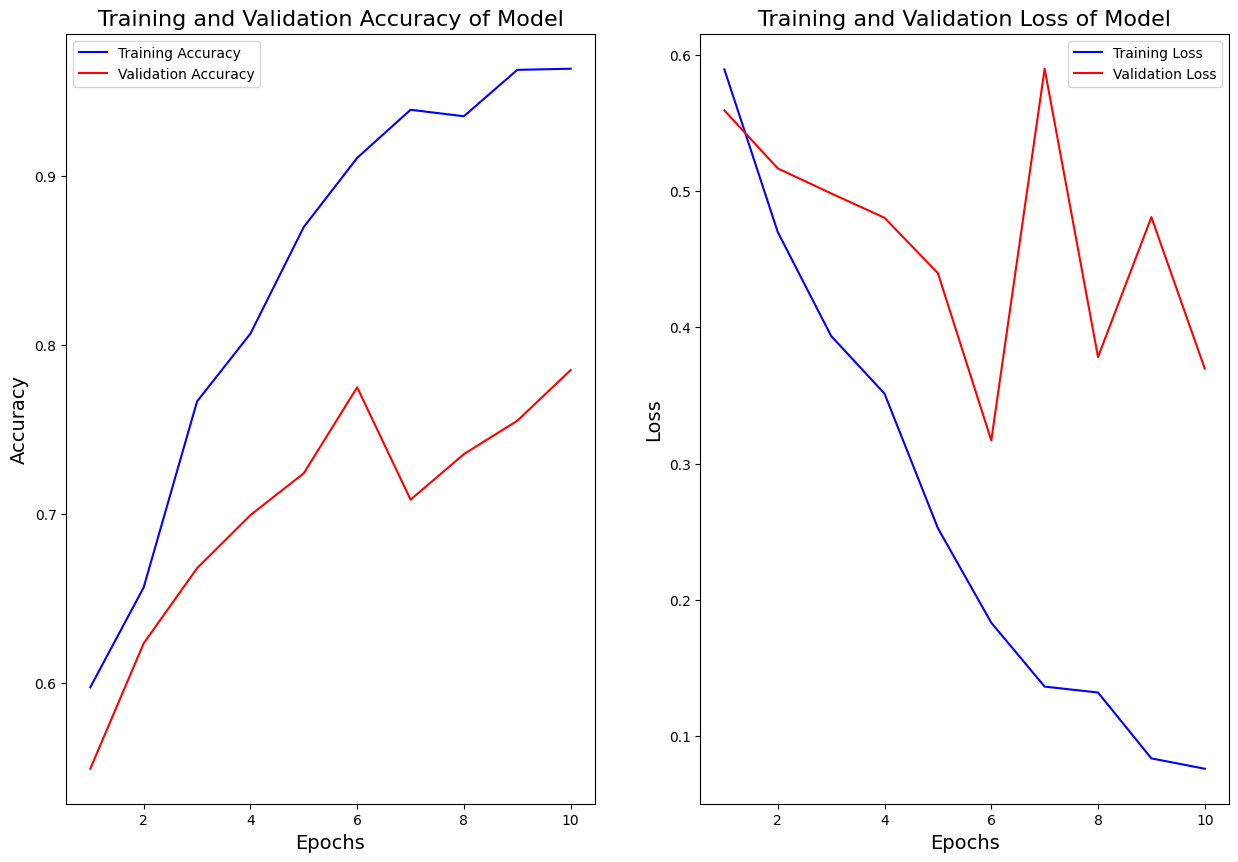

In [63]:
plot_acc_loss(history, 10)

In [64]:
torch.save(model_rms.state_dict(),'/kaggle/working/logistic_model_triangular_loss.pth')

## Model Testing and Results

In [65]:
def calculate_accuracy(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for data in data_loader:
            inputs1, inputs2, targets = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
            targets = targets.to(device)

            outputs = model(inputs1, inputs2)
            predictions = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total * 100
    return accuracy

def get_predictions(data_loader, model):
    all_preds = []
    all_labels = []
    model.eval()
    for i, data in tqdm(enumerate(data_loader, 0)):
        inputs1, inputs2, targets = data
        inputs1 = inputs1.to(device=device)
        inputs2 = inputs2.to(device=device)
        targets = targets.to(device=device)

        output = model(inputs1, inputs2)
        predictions = (output > 0.5).float().tolist()  # Convert predictions to list format
        all_preds.extend(predictions)
        all_labels.extend(targets.tolist())

    return all_preds, all_labels

def build_confusion_matrix(preds, labels):
    # Build confusion matrix
    cm = confusion_matrix(preds, labels)

    # Normalize the confusion matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Define the labels
    labels = ['Genuine', 'Forged']
    # Plot the confusion matrix
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues')
    plt.gca().set_xticklabels(labels, rotation=0)
    plt.gca().set_yticklabels(labels, rotation=0)
    # Set the axis labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Percentage)')

    # Display the plot
    plt.show()

##### confusion matrix for validation data

57it [02:09,  2.27s/it]


              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84      4989
         1.0       0.63      0.99      0.77      2298

    accuracy                           0.81      7287
   macro avg       0.81      0.86      0.81      7287
weighted avg       0.88      0.81      0.82      7287



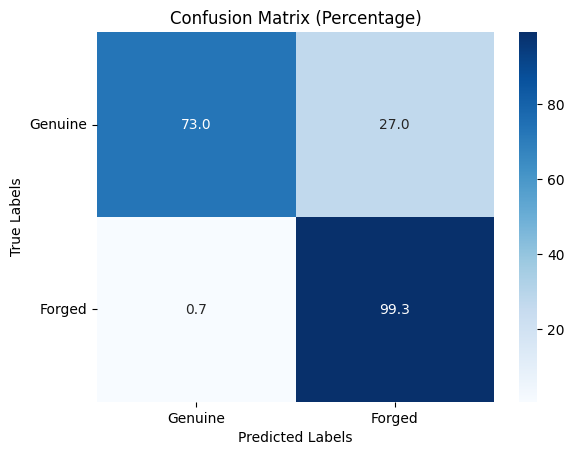

In [66]:
preds, labels = get_predictions(validation_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)

##### confusion matrix for test data

48it [01:48,  2.25s/it]


              precision    recall  f1-score   support

         0.0       1.00      0.72      0.83      4159
         1.0       0.62      0.99      0.76      1913

    accuracy                           0.80      6072
   macro avg       0.81      0.85      0.80      6072
weighted avg       0.88      0.80      0.81      6072



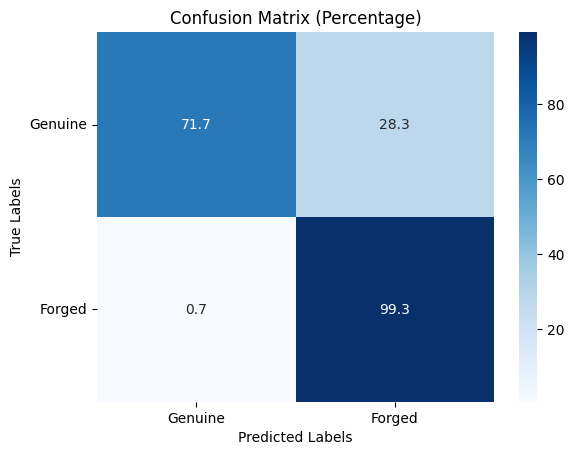

In [67]:
preds, labels = get_predictions(test_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)

##### confusion matrix for Hindi Data

375it [03:20,  1.87it/s]


              precision    recall  f1-score   support

         0.0       0.69      0.57      0.63      7290
         1.0       0.48      0.61      0.54      4710

    accuracy                           0.58     12000
   macro avg       0.59      0.59      0.58     12000
weighted avg       0.61      0.58      0.59     12000



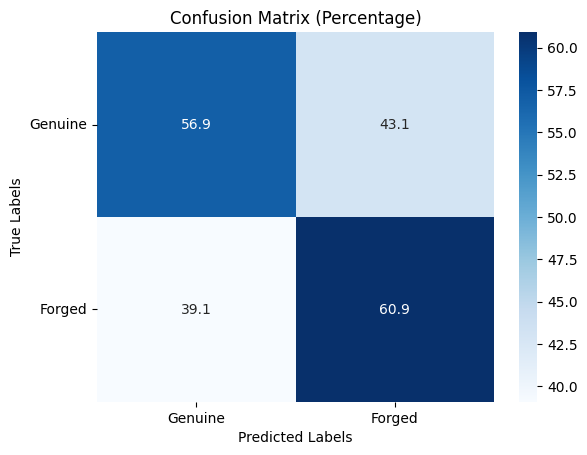

In [87]:
cedar_dataset = '/kaggle/input/handwritten-signature-datasets/BHSig260-Hindi/BHSig260-Hindi'
cedar_duplet = duplet_dataset_preparation(cedar_dataset)

cedar_duplet = cedar_duplet.sample(12000, random_state=42)

transformation = transforms.Compose([
    transforms.Resize((200,300)),
#     transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])
cedar_dataset = DupletDataset(cedar_duplet, transform=transformation)

validation_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=32
)
preds, labels = get_predictions(validation_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)

## Inference Pipeline

In [88]:
def get_predictions_for_single(img1, img2, model):
    # Load the images
    image1 = Image.open(img1)
    plt.imshow(image1)
    plt.show()
    image1 = preprocess_image(image1)
    image2 = Image.open(img2)
    plt.imshow(image2)
    plt.show()
    image2 = preprocess_image(image2)



    # Preprocess the images
    transform = transforms.Compose([
        transforms.Resize((200,300)),
#         transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ])
    input1 = transform(image1).unsqueeze(0).to(device)
    input2 = transform(image2).unsqueeze(0).to(device)

    # Make predictions using the model
    model.eval()
    with torch.no_grad():
        predictions = model(input1, input2)
        print(predictions)

    # Determine the prediction label
    if predictions > 0.8:
        print("The signatures are similar.")
    else:
        print("The signatures are not similar.")

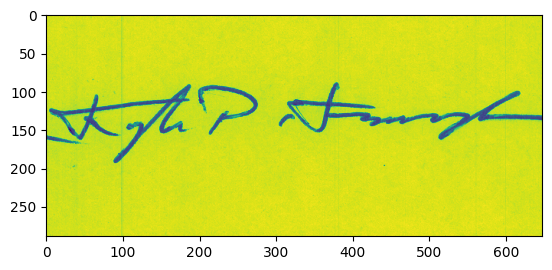

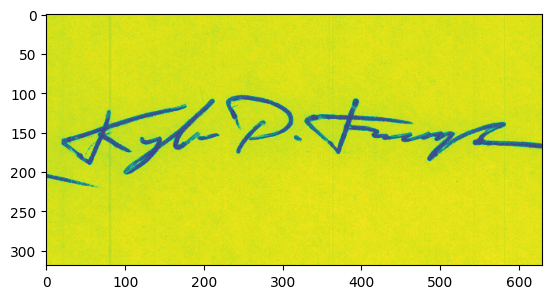

tensor([[0.9977]], device='cuda:0')
The signatures are similar.


In [89]:
img1 = "/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/11/original_11_2.png"
img2 = "/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/11/original_11_5.png"
get_predictions_for_single(img1, img2, model_rms)

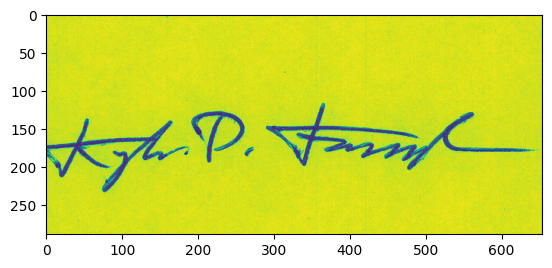

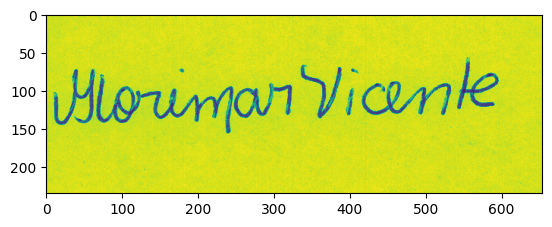

tensor([[0.4549]], device='cuda:0')
The signatures are not similar.


In [90]:
img1 = "/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/11/original_11_3.png"
img2 = "/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/2/original_2_3.png"
get_predictions_for_single(img1, img2, model_rms)

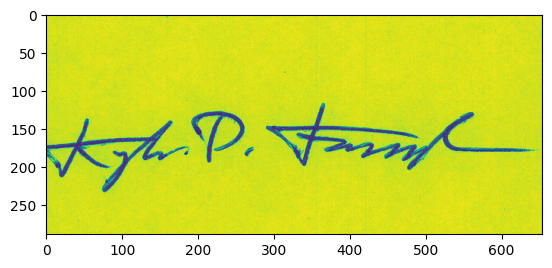

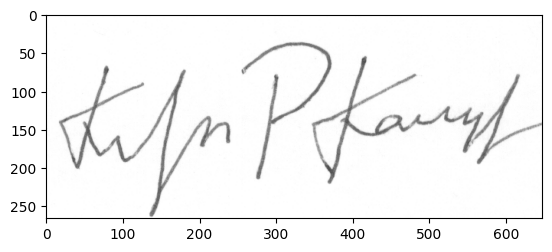

tensor([[5.1564e-08]], device='cuda:0')
The signatures are not similar.


In [91]:
img1 = "/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/11/original_11_3.png"
img2 = "/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/11/forgeries_11_3.png"
get_predictions_for_single(img1, img2, model_rms)

# Conclusion

The provided code demonstrates the process of training and evaluating a Logistic Siamese Regression (LSR) model for signature forgery detection. The model takes pairs of signature images as input and outputs a probability score between 0 and 1, where a score closer to 1 indicates that the signatures are likely to be genuine, and a score closer to 0 indicates that they are likely to be forged.

The code snippet includes the following steps:

1. **Dataset Preparation:**
    - The code defines a `triplet_dataset_preparation` function that takes a directory containing signature images as input and generates a df of tri-pairs of genuine, another different genuine and forged signatures. It then creates group of images, ensuring that each group consists of one genuine, one different agle of genuine and one forged signature.
    - The code defines a `duplet_dataset_preparation` function that takes a directory containing signature images as input and generates a df of pairs of genuine and forged signatures. It then creates pairs of images, ensuring that each pair consists of one genuine and one forged signature.

2. **Data Transformation and Preprocessing:**
    - The code defines a `transformation` object that applies a series of transformations to the signature images.
    - The transformations include resizing the images to a specific size and converting them to tensors, Random Rotation and Adding gausian blur.
    - In data preprocessing we doing: Convert Image to grayscale, GausianBlur, Binarization, Erosion, Dilation, Croping.

3. **Data Loading:**
    - The code uses the `torch.utils.data.DataLoader` class to create data loaders for training, validation, and testing.
    - The data loaders batch the data and shuffle it for efficient training and evaluation.

4. **Model Training:**
    - First we fine-tuned (transfer learning) a ResNet18 pretrained model with CEDAR dataset with CBAM integration.
    - Then the `LogisticSiameseRegression` class, which combines a trained Siamese model with a logistic regression classifier.
    - The model is trained on a dataset of genuine and forged signature pairs using the Adam optimizer and the binary cross-entropy loss function.
    - The training process is monitored using training and validation accuracy and loss metrics.

5. **Model Evaluation:**
    - The trained model is evaluated on the validation and test datasets to assess its performance.
    - The code calculates the classification accuracy and builds confusion matrices to visualize the model's predictions.
    - The results show that the model achieves high accuracy on both the validation and test datasets.

6. **Inference Pipeline:**
    - The code defines a function `get_predictions_for_single` that takes two signature images as input and outputs a prediction on their authenticity.
    - The function preprocesses the images, passes them through the trained model, and interprets the output probability score to determine if the signatures are genuine or forged.


The CNN (ResNet18 + CBAM) is converging well, but underfitting due to limited epochs and GPU constraints (free Kaggle). This affects LRN's performance (overfitting).

**To improve:**

    - Explore data augmentation (e.g., .tif files)
    - Tune hyperparameters (if time permits)
    - Consider deeper CNN (ResNet50) for better results
    - The model can still distinguish forged vs. original signs using inference.

Focus on increasing epochs/data augmentation first. If resources allow, experiment with ResNet50. Make changes incrementally, evaluate, and adjust. Consider regularization to prevent overfitting.

**Val Accuracy = 76%**

Can Detect forge and original Sign if we provide two images directly using Infernece function.

Overall, the provided code demonstrates the effectiveness of using a Logistic Siamese Regression model for signature forgery detection. The model can be used to analyze pairs of signature images and provide an assessment of their authenticity.

In [92]:
from IPython.display import FileLink
FileLink(r'logistic_model_triangular_loss.pth')

/kaggle/working/logistic_model_triangular_loss.pth

In [93]:
FileLink(r'signature_forgery_detection_model')

/kaggle/working/signature_forgery_detection_model